In [1]:
import sys
import tqdm
import torch
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import pyarrow.parquet as pq

from matplotlib import pyplot as plt
from transformers import T5Tokenizer, T5EncoderModel

torch.set_float32_matmul_precision('medium')

/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
parquet_path = "../data/frustration/v8_frustration_v2.parquet.gzip"
df = pq.read_table(parquet_path).to_pandas()
df = df.sample(n=100, random_state=42).reset_index(drop=True)

In [6]:
len(df)

983212

In [5]:
df["proteinID"].nunique()

983212

In [212]:
labels = np.concatenate(df["frst_class_3"].to_numpy())
np.bincount(labels) / len(labels)

array([0.12543113, 0.48395942, 0.39060945])

In [214]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights / class_weights[0]

array([1.        , 0.25917696, 0.32111647])

In [215]:
class_weights

array([2.65750085, 0.68876299, 0.8533673 ])

## ProstT5

In [102]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
pLM_model = "../data/prostT5"
prefix_prostT5 = "<AA2fold>"
max_seq_length = 256
tokenizer = T5Tokenizer.from_pretrained(pLM_model, do_lower_case=False, max_length=max_seq_length)
encoder = T5EncoderModel.from_pretrained(pLM_model).to(device)

if "cuda" in device:
    encoder.half()
    print("Using half precision for the pLM encoder")

In [103]:
frust_avail = []
embeddings = []
res_labels = []
frst_val = []
frst_class = []

for row in tqdm.tqdm(df.iterrows()):
    idx = min(len(row[1]["full_seq"]), max_seq_length)

    full_seq = [prefix_prostT5 + " " + " ".join(seq) for seq in [row[1]["full_seq"]]]  # Add spaces between amino acids and prefix
    ids = tokenizer.batch_encode_plus(full_seq,
                                    add_special_tokens=True,
                                    max_length=max_seq_length,
                                    padding="max_length",
                                    truncation="longest_first",
                                    return_tensors='pt'
                                    ).to(device)

    with torch.no_grad():
        embedding_rpr = encoder(
            ids.input_ids,
            attention_mask=ids.attention_mask
        )
    emb = embedding_rpr.last_hidden_state[0, 1:idx,]
    embeddings.append(emb)
    res_labels.append(list(row[1]["full_seq"])[:idx-1])

    frsts = torch.zeros((len(row[1]["full_seq"])), dtype=torch.bool)
    frsts[row[1]["res_idx"]] = True
    frust_avail.append(frsts[:idx-1])
    vals = np.zeros((len(row[1]["full_seq"])))
    vals[:] = np.nan
    vals[row[1]["res_idx"]] = row[1]["frst_idx"]
    frst_val.append(vals[:idx-1])
    classes = np.zeros((len(row[1]["full_seq"])), dtype=object)
    classes[row[1]["res_idx"]] = row[1]["frst_class"]
    frst_class.append(classes[:idx-1])


100it [00:34,  2.88it/s]


In [104]:
adata = sc.AnnData(X=torch.cat(embeddings, dim=0).cpu().numpy())
adata.obs['frustration'] = torch.cat(frust_avail, dim=0).cpu().numpy()
adata.obs['residue'] = np.concatenate(res_labels, axis=0)
adata.obs['frst_val'] = np.concatenate(frst_val, axis=0)
adata.obs['frst_class'] = np.concatenate(frst_class, axis=0)
adata.obs['frst_class'] = adata.obs['frst_class'].astype('category')

In [105]:
adata

AnnData object with n_obs × n_vars = 24481 × 1024
    obs: 'frustration', 'residue', 'frst_val', 'frst_class'

In [106]:
adata_frst = adata[adata.obs['frustration'] == True, :].copy()
adata_frst

AnnData object with n_obs × n_vars = 10997 × 1024
    obs: 'frustration', 'residue', 'frst_val', 'frst_class'

In [107]:
sc.pp.pca(adata_frst)
sc.pp.neighbors(adata_frst)
sc.tl.umap(adata_frst)

In [108]:
property_dict = {
    'A': 'hydrophobic', 'V': 'hydrophobic', 'I': 'hydrophobic', 'L': 'hydrophobic', 'M': 'moderate',
    'F': 'hydrophobic', 'Y': 'hydrophobic', 'W': 'hydrophobic',
    'R': 'positive', 'H': 'positive', 'K': 'positive',
    'D': 'negative', 'E': 'negative',
    'S': 'hydrophilic', 'T': 'hydrophilic', 'N': 'hydrophilic', 'Q': 'hydrophilic',
    'C': 'special', 'G': 'special', 'P': 'special'
}

In [109]:
adata_frst.obs['residue_property'] = adata_frst.obs['residue'].map(property_dict)

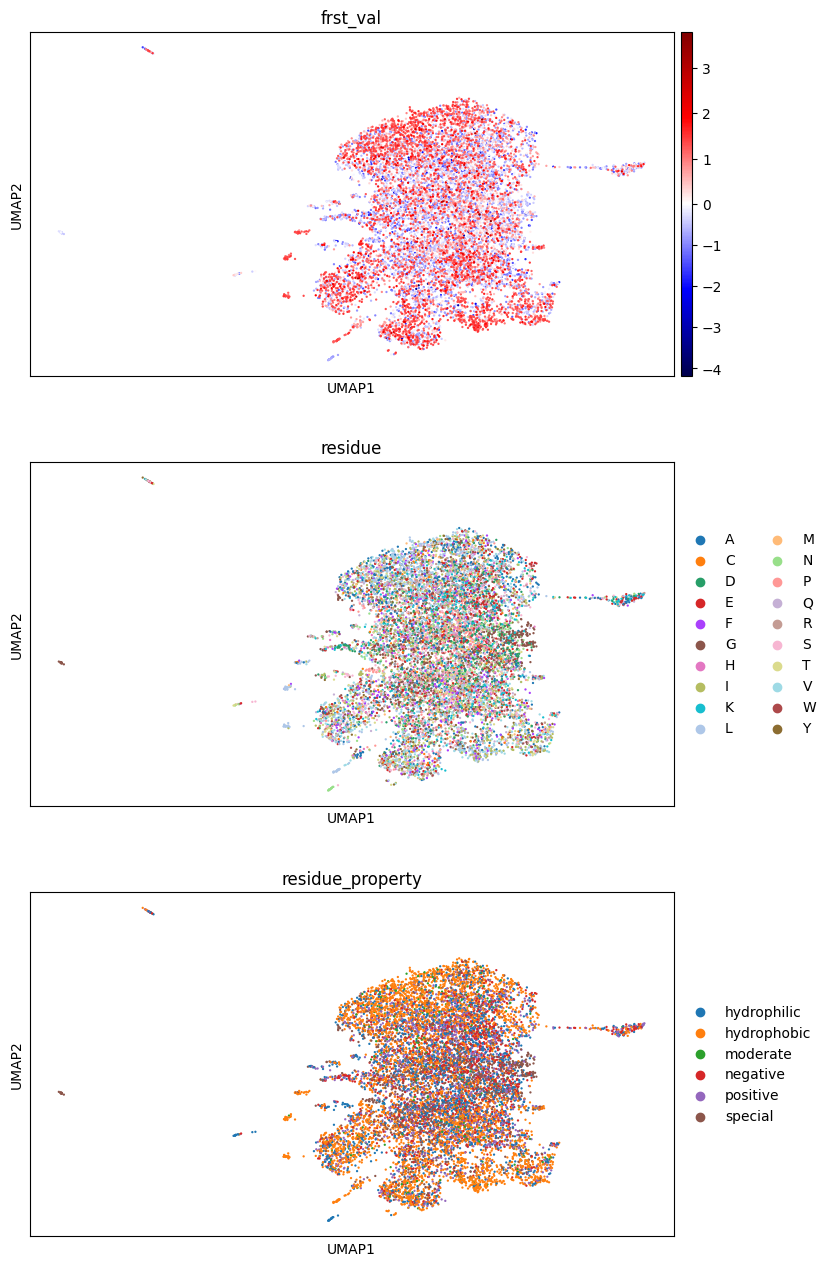

In [110]:
sc.pl.umap(adata_frst, color=['frst_val', 'residue', "residue_property"], ncols=1, wspace=0.4, cmap='seismic', vcenter=0,) #palette="tab20")

In [73]:
len(df.iloc[0]["full_seq"])

309

In [74]:
full_seq = [prefix_prostT5 + " " + " ".join(df.iloc[0]["full_seq"])]
ids = tokenizer.batch_encode_plus(full_seq,
                                add_special_tokens=True,
                                max_length=max_seq_length,
                                padding="max_length",
                                truncation="longest_first",
                                return_tensors='pt'
                                ).to(device)

with torch.no_grad():
    embedding_rpr = encoder(
        ids.input_ids,
        attention_mask=ids.attention_mask
    )
emb = embedding_rpr.last_hidden_state[0, 1:,]
emb.shape

torch.Size([255, 1024])

In [75]:
adata_dummy = sc.AnnData(X=emb.cpu().numpy())
adata_dummy.obs['residue'] = list(df.iloc[0]["full_seq"])[:max_seq_length-1]
adata_dummy.obs['residue'] = adata_dummy.obs['residue'].astype('category')
adata_dummy

AnnData object with n_obs × n_vars = 255 × 1024
    obs: 'residue'

In [82]:
df.iloc[0]["full_seq"][254]

'D'

In [76]:
adata_dummy.obs

,residue
0,M
1,S
2,S
3,Q
4,P
...,...
250,R
251,L
252,D
253,T


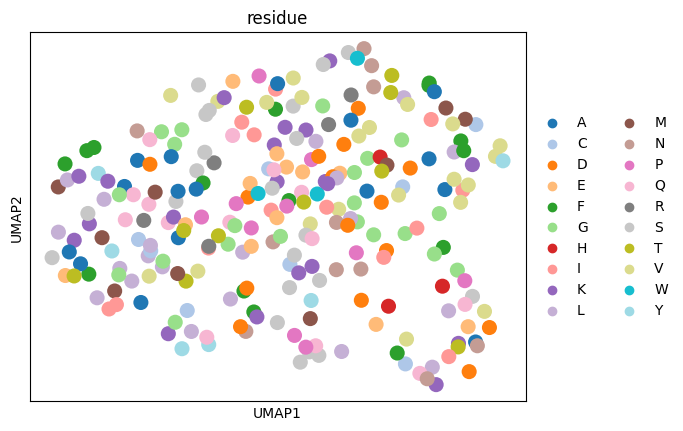

In [77]:
sc.pp.neighbors(adata_dummy, use_rep='X')
sc.tl.umap(adata_dummy)
sc.pl.umap(adata_dummy, color=['residue'], palette="tab20")

## ProtT5

In [3]:
df.head(2)

,proteinID,full_seq,res_seq,res_idx,frst_idx,frst_class,frst_class_3,split_test,cath_id,cath_T_id,split_old,split_0,split_1,split_2,split_3
0,AF-A0A840LZX6-F1-model_v4_TED01,MIFQARPRPVLPSFADHGRSTGAHHYDVVIIGGGYTGLSTARYLAQ...,"[P, S, F, A, D, H, G, R, S, T, G, A, H, H, Y, ...","[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 2...","[-0.142, -0.305, 0.829, -1.228, 2.168, 1.148, ...","[f11, f11, f9, f13, f6, f8, f10, f7, f10, f10,...","[1, 1, 2, 0, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, ...",train,3.50.50.60,3.50.50,train,train,train,train,val
1,AF-A0A1U7RT13-F1-model_v4_TED01,MATKSRKYRALSELLPFQSSSDRKGCFALPRSSATTHRSRCGEEKC...,"[S, L, I, S, N, H, S, R, Y, V, E, S, F, R, L, ...","[88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 9...","[-0.645, 0.784, 0.539, -0.408, -0.947, -0.16, ...","[f12, f9, f9, f11, f13, f11, f11, f11, f9, f8,...","[1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, ...",train,3.40.50.150,3.40.50,train,train,train,train,train


In [4]:
fasta_file_path = "../data/frustration/bonomi_ensembles_sequences.fasta"

In [5]:
seqs = {}
with open(fasta_file_path, 'r') as f:
    fasta_data = f.read()
    for line in fasta_data.splitlines():
        if line.startswith(">"):
            header = line[1:]
            seqs[header] = ""
        else:
            seqs[header] += line.strip()
seqs

{'Alb3-A3CT': 'MDENASKIISAGRAKRSIAQPDDAGERFRQLKEQEKRSKKNKAVAKDTVELVEESQSESEEGSDDEEEEAREGALASSTTSKPLPEVGQRRSKRSKRKRTV',
 'FCP1': 'PGPEEQEEEPQPRKPGTRRERTLGAPASSERSAAGGRGPRGHKRKLNEEDAASESSRESSNEDEGSSSEADEMAKALEAELNDLM',
 'emerin_67-170': 'GTRGDADMYDLPKKEDALLYQSKGYNDDYYEESYFTTRTYGEPESAGPSRAVRQSVTSFPDADAFHHQVHDDDLLSSSEEECKDRERPMYGRDSAYQSITHYRPV',
 'UBact': 'MIQSLMPERRERPGDPMPKSPSPLEEGGGPRRPETGSPDKDSLLKRMRRVDPKQAERYRQRTGE',
 'Nsp2_CtlIDR': 'KEIIFLEGETLPTEVLTEEVVLKTGDLQPLEQPTSEAVEAPLVGT',
 'NHE1': 'MINNYLTVPAHKLDSPTMSRARIGSDPLAYEPKEDLPVITIDPASPQSPESVDLVNEELKGKVLGLSRDPAKVAEEDEDDDGGIMMRSKETSSPGTDDVFTPAPSDSPSSQRIQRCLSDP',
 'p61_Hck': 'GGRSSCEDPGCPRDEERAPRMGCMKSKFLQVGGNTFSKTETSASPHCPVYVPDPTSTIKPGPNSHNSNTPGIREAGSE',
 'ACTR': 'GTQNRPLLRNSLDDLVGPPSNLEGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPKQD',
 'Hug1': 'AMADPMTMDQGLNPKQFFLDDVVLQDTLCSMSNRVNKSVKTGYLFPKDHVPSANIIAVERRGGLSDIGKNTSN',
 'PaaA2': 'MDYKDDDDKNRALSPMVSEFETIEQENSYNEWLRAKVATSLADPRPAIPHDEVERRMAERFAKMRKERSKQ',
 'Nt-SOCS5': 'RSLRQRLQDTVGLCFPM

In [6]:
df_idp = pd.DataFrame.from_dict(seqs, orient='index', columns=["full_seq"]).reset_index().rename(columns={'index':'proteinID'})
df_idp

,proteinID,full_seq
0,Alb3-A3CT,MDENASKIISAGRAKRSIAQPDDAGERFRQLKEQEKRSKKNKAVAK...
1,FCP1,PGPEEQEEEPQPRKPGTRRERTLGAPASSERSAAGGRGPRGHKRKL...
2,emerin_67-170,GTRGDADMYDLPKKEDALLYQSKGYNDDYYEESYFTTRTYGEPESA...
3,UBact,MIQSLMPERRERPGDPMPKSPSPLEEGGGPRRPETGSPDKDSLLKR...
4,Nsp2_CtlIDR,KEIIFLEGETLPTEVLTEEVVLKTGDLQPLEQPTSEAVEAPLVGT
5,NHE1,MINNYLTVPAHKLDSPTMSRARIGSDPLAYEPKEDLPVITIDPASP...
6,p61_Hck,GGRSSCEDPGCPRDEERAPRMGCMKSKFLQVGGNTFSKTETSASPH...
7,ACTR,GTQNRPLLRNSLDDLVGPPSNLEGQSDERALLDQLHTLLSNTDATG...
8,Hug1,AMADPMTMDQGLNPKQFFLDDVVLQDTLCSMSNRVNKSVKTGYLFP...
9,PaaA2,MDYKDDDDKNRALSPMVSEFETIEQENSYNEWLRAKVATSLADPRP...


In [47]:
df_idp["res_seq"] = [[0] * 256 for _ in range(len(df_idp))]
df_idp["res_idx"] = [[0] * 256 for _ in range(len(df_idp))]
df_idp["frst_class_3"] = [[0] * 256 for _ in range(len(df_idp))]
df_idp["frst_idx"] = [[0.0] * 256 for _ in range(len(df_idp))]

In [ ]:
df_embed = pd.concat([df_idp, df])
df_embed

,proteinID,full_seq,res_seq,res_idx,frst_idx,frst_class,frst_class_3,split_test,cath_id,cath_T_id,split_old,split_0,split_1,split_2,split_3
0,AF-A0A840LZX6-F1-model_v4_TED01,MIFQARPRPVLPSFADHGRSTGAHHYDVVIIGGGYTGLSTARYLAQ...,"[P, S, F, A, D, H, G, R, S, T, G, A, H, H, Y, ...","[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 2...","[-0.142, -0.305, 0.829, -1.228, 2.168, 1.148, ...","[f11, f11, f9, f13, f6, f8, f10, f7, f10, f10,...","[1, 1, 2, 0, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, ...",train,3.50.50.60,3.50.50,train,train,train,train,val
1,AF-A0A1U7RT13-F1-model_v4_TED01,MATKSRKYRALSELLPFQSSSDRKGCFALPRSSATTHRSRCGEEKC...,"[S, L, I, S, N, H, S, R, Y, V, E, S, F, R, L, ...","[88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 9...","[-0.645, 0.784, 0.539, -0.408, -0.947, -0.16, ...","[f12, f9, f9, f11, f13, f11, f11, f11, f9, f8,...","[1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, ...",train,3.40.50.150,3.40.50,train,train,train,train,train
2,AF-A0A2D7AHP0-F1-model_v4_TED01,MGLLVDGKWVDQWYDTKAAGGRFKRKASAFRDWVRADGSTPFLPES...,"[L, V, D, G, K, W, V, D, Q, W, Y, D, T, K, A, ...","[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...","[1.188, 1.891, 1.759, -0.266, -0.864, 0.377, 1...","[f8, f6, f7, f11, f12, f10, f8, f11, f13, f13,...","[2, 2, 2, 1, 1, 1, 2, 1, 0, 0, 0, 2, 1, 2, 1, ...",train,3.40.30.10,3.40.30,train,train,train,train,train
3,AF-A0A3Q3EA93-F1-model_v4_TED04,MDIRTKFSVCWEGCRTCFKKSNSSGIKNDTPKKEPVVVIENPSAVR...,"[K, G, A, K, L, K, L, S, D, Q, I, E, M, A, A, ...","[334, 335, 336, 337, 338, 339, 340, 341, 342, ...","[-1.562, -0.635, -0.151, 0.028, 1.107, 0.407, ...","[f14, f12, f11, f10, f8, f10, f7, f12, f10, f1...","[0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 0, 2, 2, 1, ...",train,1.10.510.10,1.10.510,test,train,train,train,train
4,AF-A0A496NHB6-F1-model_v4_TED01,QEFFGKEPRKDVNPDEAVAMGAAIQGAVLSGDKKDVLLLDVTPLTL...,"[V, T, P, L, T, L, G, I, E, T, M, G, G, V, M, ...","[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 5...","[0.961, -0.145, -1.013, 1.155, 0.216, 1.599, -...","[f8, f11, f13, f8, f10, f7, f11, f7, f13, f11,...","[2, 1, 0, 2, 1, 2, 1, 2, 0, 1, 2, 1, 1, 2, 2, ...",train,2.60.34.10,2.60.34,train,train,train,train,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,Ab40,DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVV,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,Colicin_N_T_domain,GSNGADNAHNNAFGGGKNPGIGNTSGAGSNGSASSNRGNSNGWSWS...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,asyn,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,idr_SSRP1,GSHMGYKDVDFGDSDNENEPDAYLARLKAEAREKEEDDDDGDSDEE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
pLM_model = "../data/protT5"
max_seq_length = 256
tokenizer = T5Tokenizer.from_pretrained(pLM_model, do_lower_case=False, max_length=max_seq_length)
encoder = T5EncoderModel.from_pretrained(pLM_model).to(device)

if "cuda" in device:
    encoder.half()
    print("Using half precision for the pLM encoder")

In [7]:
frust_avail = []
embeddings = []
res_labels = []
frst_val = []
frst_class = []
#idp = []
#use df_embed for combined IDP + frustration data
for row in tqdm.tqdm(df.iterrows()):
    idx = min(len(row[1]["full_seq"]), max_seq_length)

    full_seq = [" ".join(seq) for seq in [row[1]["full_seq"]]]  # Add spaces between amino acids and prefix
    ids = tokenizer.batch_encode_plus(full_seq,
                                    add_special_tokens=True,
                                    max_length=max_seq_length,
                                    padding="max_length",
                                    truncation="longest_first",
                                    return_tensors='pt'
                                    ).to(device)

    with torch.no_grad():
        embedding_rpr = encoder(
            ids.input_ids,
            attention_mask=ids.attention_mask
        )
    emb = embedding_rpr.last_hidden_state[0, :idx,]
    embeddings.append(emb)
    res_labels.append(list(row[1]["full_seq"])[:idx])

    frsts = torch.zeros((len(row[1]["full_seq"])), dtype=torch.bool)
    frsts[row[1]["res_idx"]] = True
    frust_avail.append(frsts[:idx])
    vals = np.zeros((len(row[1]["full_seq"])))
    vals[:] = np.nan
    vals[row[1]["res_idx"]] = row[1]["frst_idx"]
    frst_val.append(vals[:idx])
    classes = np.zeros((len(row[1]["full_seq"])), dtype=object)
    classes[row[1]["res_idx"]] = row[1]["frst_class_3"]
    frst_class.append(classes[:idx])
    #is_idp = row[1]["proteinID"] in df_idp["proteinID"].values
    #idp.append([is_idp] * len(list(row[1]["full_seq"])[:idx]))


100it [00:30,  3.32it/s]


In [50]:
row[1]["proteinID"]

'His-PknG_1-75'

In [8]:
adata = sc.AnnData(X=torch.cat(embeddings, dim=0).cpu().numpy())
adata.obs['frustration'] = torch.cat(frust_avail, dim=0).cpu().numpy()
adata.obs['residue'] = np.concatenate(res_labels, axis=0)
adata.obs['frst_val'] = np.concatenate(frst_val, axis=0)
adata.obs['frst_class'] = np.concatenate(frst_class, axis=0)
adata.obs['frst_class'] = adata.obs['frst_class'].astype('category')
#adata.obs['is_idp'] = np.concatenate(idp, axis=0).astype(bool)

In [ ]:
adata.obs["is_idp"].sum()

np.int64(1337)

In [53]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

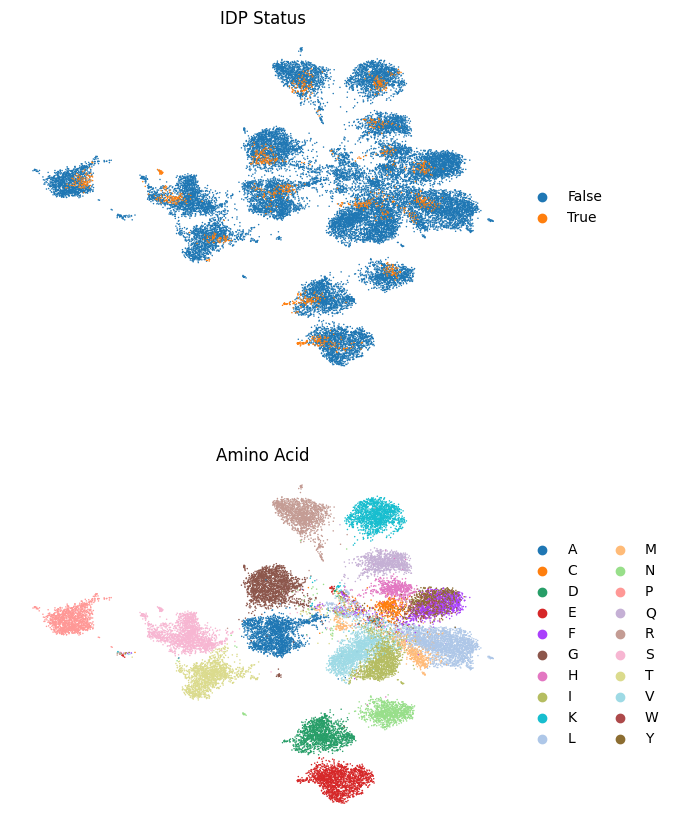

In [55]:
sc.pl.umap(adata, color=['is_idp', 'residue',], ncols=1, wspace=0.1, frameon=False, title=['IDP Status', 'Amino Acid'])

In [9]:
adata_frst = adata[adata.obs['frustration'] == True, :].copy()
adata_frst #11947

AnnData object with n_obs × n_vars = 11947 × 1024
    obs: 'frustration', 'residue', 'frst_val', 'frst_class'

In [10]:
sc.pp.pca(adata_frst)
sc.pp.neighbors(adata_frst)
sc.tl.umap(adata_frst)

In [11]:
property_dict = {
    'A': 'hydrophobic', 'V': 'hydrophobic', 'I': 'hydrophobic', 'L': 'hydrophobic', 'M': 'moderate',
    'F': 'hydrophobic', 'Y': 'hydrophobic', 'W': 'hydrophobic',
    'R': 'positive', 'H': 'positive', 'K': 'positive',
    'D': 'negative', 'E': 'negative',
    'S': 'hydrophilic', 'T': 'hydrophilic', 'N': 'hydrophilic', 'Q': 'hydrophilic',
    'C': 'special', 'G': 'special', 'P': 'special'
}

In [12]:
adata_frst.obs['residue_property'] = adata_frst.obs['residue'].map(property_dict)

In [13]:
adata_outlier_removed = adata_frst[adata_frst.obsm['X_umap'][:, 0] < 10, :].copy()
adata_outlier_removed

AnnData object with n_obs × n_vars = 11900 × 1024
    obs: 'frustration', 'residue', 'frst_val', 'frst_class', 'residue_property'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

<Figure size 1800x900 with 0 Axes>

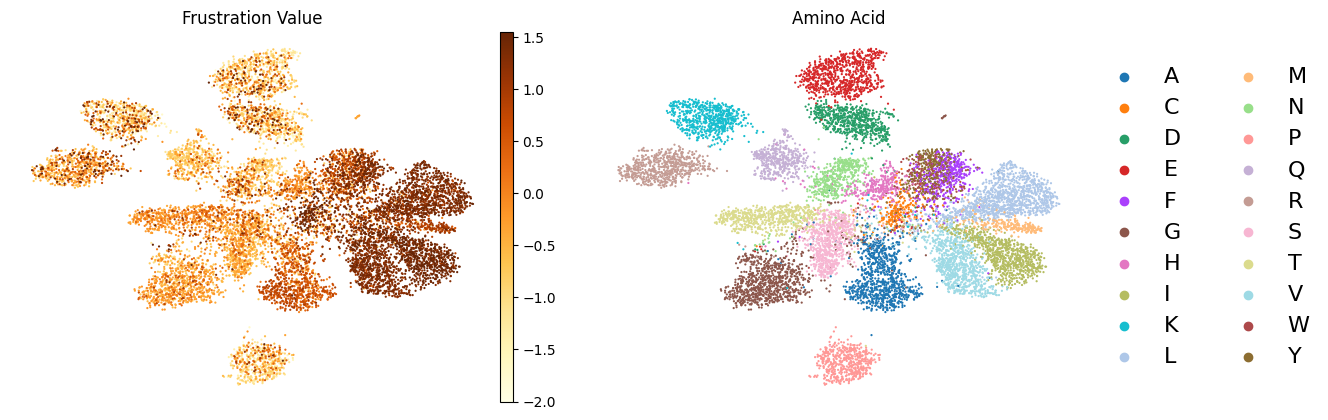

In [14]:
plt.figure(figsize=(12,6), dpi=150)
fig = sc.pl.umap(adata_outlier_removed, color=['frst_val', 'residue',], ncols=2, wspace=0.1, cmap="YlOrBr", vmin=-2, vmax=1.55,
           frameon=False, title=['Frustration Value', 'Amino Acid'], legend_fontsize=16, return_fig=True)
#plt.
#plt.savefig("umap_frustration_prostT5.png", dpi=180)

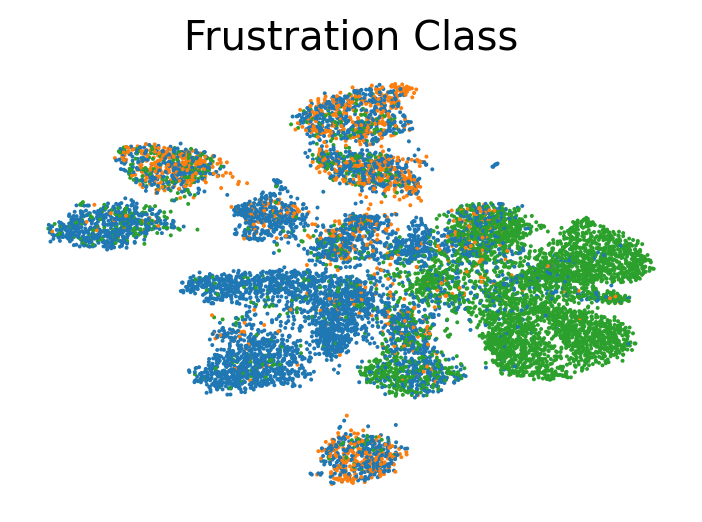

In [19]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=180)
"""sc.pl.umap(adata_outlier_removed, color='frst_val', cmap="rocket", vmin=-2, vmax=1.55, vcenter=np.mean([-1, 0.55]),
           ax=ax, show=False, frameon=False, legend_fontsize=16,)"""
sc.pl.umap(adata_outlier_removed, color='frst_class', cmap="rocket", palette={0: "C1", 1: "C0", 2: "C2"}, vmin=-2, vmax=1.55, vcenter=np.mean([-1, 0.55]),
           ax=ax, show=False, frameon=False, legend_fontsize=16, legend_loc=None)

ax.set_title("Frustration Class", fontsize=16)

# Fix colorbar text size
# Scanpy attaches colorbars to the figure, not the axis → iterate and modify:
for cbar in fig.axes:
    if hasattr(cbar, 'get_ylabel') and cbar is not ax:
        cbar.tick_params(labelsize=14)   # tick size
        try:
            cbar.set_ylabel(cbar.get_ylabel(), fontsize=12)
        except:
            pass

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Amino Acid')

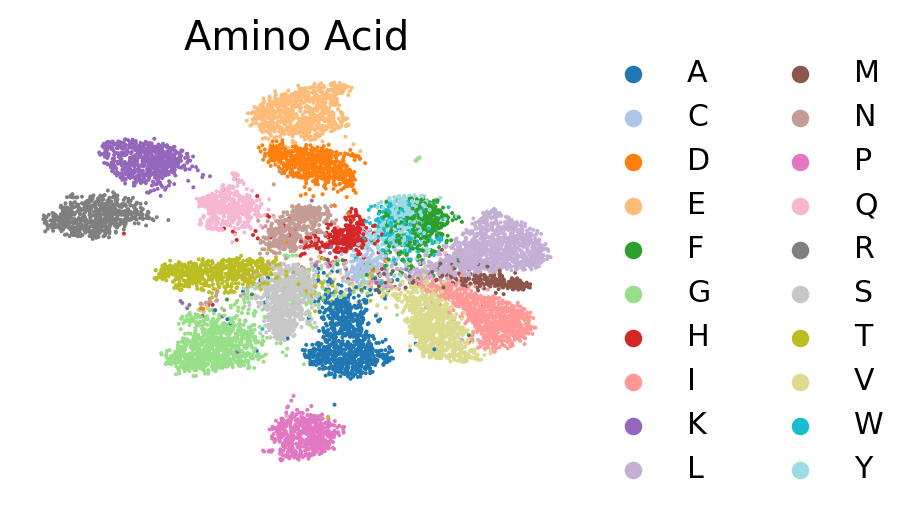

In [137]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=180)
sc.pl.umap(adata_outlier_removed, color='residue', palette="tab20",
           ax=ax, show=False, frameon=False, legend_fontsize=12,)

ax.set_title("Amino Acid", fontsize=16)

In [174]:
1 - (11900/11947)

0.0039340420189168945

In [172]:
adata_outlier_removed

AnnData object with n_obs × n_vars = 11900 × 1024
    obs: 'frustration', 'residue', 'frst_val', 'frst_class', 'residue_property'
    uns: 'pca', 'neighbors', 'umap', 'residue_colors', 'residue_property_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

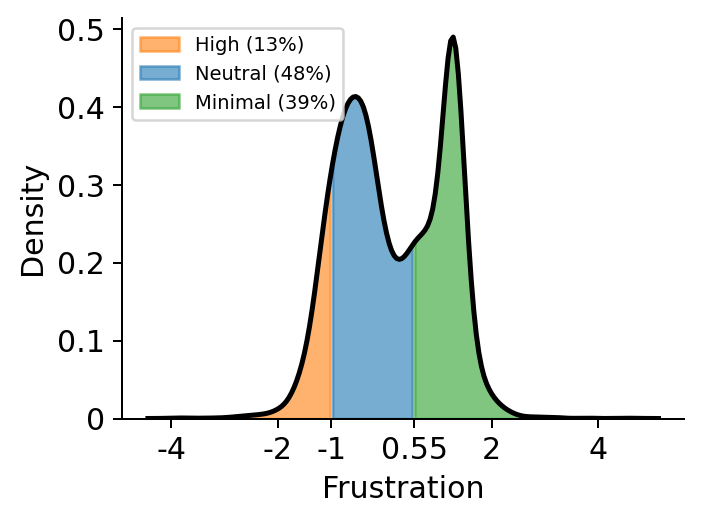

In [200]:
vals = adata_frst.obs['frst_val'].dropna()

# Plot KDE and capture the line
fig, ax = plt.subplots(figsize=(4, 3), dpi=180)
kde = sns.kdeplot(vals, fill=False, ax=ax, color="black", linewidth=2)
sns.despine(ax=ax)

# Extract the x/y data the KDE line is using
line = ax.lines[0]
x = line.get_xdata()
y = line.get_ydata()

# Define thresholds
t1 = -1
t2 = 0.55

# Shade regions
ax.fill_between(x, y, where=(x <= t1), color="C1", alpha=0.6, label="High (13%)")
ax.fill_between(x, y, where=( (x > t1) & (x <= t2) ), color="C0", alpha=0.6, label="Neutral (48%)")
ax.fill_between(x, y, where=(x > t2), color="C2", alpha=0.6, label="Minimal (39%)")

ax.set_xlabel("Frustration", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.set_title("",)
ax.set_xticks([-4, -2, -1, 0.55, 2, 4])
ax.set_xticklabels([-4, -2, -1, 0.55, 2, 4], fontsize=12)
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_yticklabels( [0, 0.1, 0.2, 0.3, 0.4, 0.5], fontsize=12)
ax.legend(loc='upper left', fontsize=7.8)

plt.tight_layout()
plt.show()


In [1]:
fasta_file_path = "../data/frustration/bonomi_ensembles_sequences.fasta"

In [3]:
seqs = {}
with open(fasta_file_path, 'r') as f:
    fasta_data = f.read()
    for line in fasta_data.splitlines():
        if line.startswith(">"):
            header = line[1:]
            seqs[header] = ""
        else:
            seqs[header] += line.strip()
seqs

{'Alb3-A3CT': 'MDENASKIISAGRAKRSIAQPDDAGERFRQLKEQEKRSKKNKAVAKDTVELVEESQSESEEGSDDEEEEAREGALASSTTSKPLPEVGQRRSKRSKRKRTV',
 'FCP1': 'PGPEEQEEEPQPRKPGTRRERTLGAPASSERSAAGGRGPRGHKRKLNEEDAASESSRESSNEDEGSSSEADEMAKALEAELNDLM',
 'emerin_67-170': 'GTRGDADMYDLPKKEDALLYQSKGYNDDYYEESYFTTRTYGEPESAGPSRAVRQSVTSFPDADAFHHQVHDDDLLSSSEEECKDRERPMYGRDSAYQSITHYRPV',
 'UBact': 'MIQSLMPERRERPGDPMPKSPSPLEEGGGPRRPETGSPDKDSLLKRMRRVDPKQAERYRQRTGE',
 'Nsp2_CtlIDR': 'KEIIFLEGETLPTEVLTEEVVLKTGDLQPLEQPTSEAVEAPLVGT',
 'NHE1': 'MINNYLTVPAHKLDSPTMSRARIGSDPLAYEPKEDLPVITIDPASPQSPESVDLVNEELKGKVLGLSRDPAKVAEEDEDDDGGIMMRSKETSSPGTDDVFTPAPSDSPSSQRIQRCLSDP',
 'p61_Hck': 'GGRSSCEDPGCPRDEERAPRMGCMKSKFLQVGGNTFSKTETSASPHCPVYVPDPTSTIKPGPNSHNSNTPGIREAGSE',
 'ACTR': 'GTQNRPLLRNSLDDLVGPPSNLEGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPKQD',
 'Hug1': 'AMADPMTMDQGLNPKQFFLDDVVLQDTLCSMSNRVNKSVKTGYLFPKDHVPSANIIAVERRGGLSDIGKNTSN',
 'PaaA2': 'MDYKDDDDKNRALSPMVSEFETIEQENSYNEWLRAKVATSLADPRPAIPHDEVERRMAERFAKMRKERSKQ',
 'Nt-SOCS5': 'RSLRQRLQDTVGLCFPM

In [5]:
df = pd.DataFrame.from_dict(seqs, orient='index', columns=["sequence"]).reset_index().rename(columns={'index':'id'})

In [6]:
df.head()

,id,sequence
0,Alb3-A3CT,MDENASKIISAGRAKRSIAQPDDAGERFRQLKEQEKRSKKNKAVAK...
1,FCP1,PGPEEQEEEPQPRKPGTRRERTLGAPASSERSAAGGRGPRGHKRKL...
2,emerin_67-170,GTRGDADMYDLPKKEDALLYQSKGYNDDYYEESYFTTRTYGEPESA...
3,UBact,MIQSLMPERRERPGDPMPKSPSPLEEGGGPRRPETGSPDKDSLLKR...
4,Nsp2_CtlIDR,KEIIFLEGETLPTEVLTEEVVLKTGDLQPLEQPTSEAVEAPLVGT


In [7]:
max_seq_length = df["sequence"].str.len().max()
max_seq_length

np.int64(140)

In [ ]:
frust_avail = []
embeddings = []
res_labels = []
frst_val = []
frst_class = []

for row in tqdm.tqdm(df.iterrows()):
    idx = min(len(row[1]["full_seq"]), max_seq_length)
    print(idx, max_seq_length)

    full_seq = [" ".join(seq) for seq in [row[1]["full_seq"]]]  # Add spaces between amino acids and prefix
    ids = tokenizer.batch_encode_plus(full_seq,
                                    add_special_tokens=True,
                                    max_length=max_seq_length,
                                    padding="max_length",
                                    truncation="longest_first",
                                    return_tensors='pt'
                                    ).to(device)

    with torch.no_grad():
        embedding_rpr = encoder(
            ids.input_ids,
            attention_mask=ids.attention_mask
        )
    emb = embedding_rpr.last_hidden_state[0, :idx,]
    embeddings.append(emb)
    res_labels.append(list(row[1]["full_seq"])[:idx])

    frsts = torch.zeros((len(row[1]["full_seq"])), dtype=torch.bool)
    frsts[row[1]["res_idx"]] = True
    frust_avail.append(frsts[:idx])
    vals = np.zeros((len(row[1]["full_seq"])))
    vals[:] = np.nan
    vals[row[1]["res_idx"]] = row[1]["frst_idx"]
    frst_val.append(vals[:idx])
    classes = np.zeros((len(row[1]["full_seq"])), dtype=object)
    classes[row[1]["res_idx"]] = row[1]["frst_class_3"]
    frst_class.append(classes[:idx])

adata = sc.AnnData(X=torch.cat(embeddings, dim=0).cpu().numpy())
adata.obs['frustration'] = torch.cat(frust_avail, dim=0).cpu().numpy()
adata.obs['residue'] = np.concatenate(res_labels, axis=0)
adata.obs['frst_val'] = np.concatenate(frst_val, axis=0)
adata.obs['frst_class'] = np.concatenate(frst_class, axis=0)
adata.obs['frst_class'] = adata.obs['frst_class'].astype('category')